In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("cleaned_btc_15m_02.csv")
print(data)

                       Date      Open      High       Low     Close  \
0       2020-01-01 00:00:00   7195.24   7196.25   7178.20   7180.97   
1       2020-01-01 00:15:00   7180.97   7186.40   7175.47   7178.45   
2       2020-01-01 00:30:00   7178.19   7185.44   7176.23   7179.56   
3       2020-01-01 00:45:00   7179.35   7183.98   7175.46   7177.02   
4       2020-01-01 01:00:00   7176.47   7194.04   7175.71   7190.86   
...                     ...       ...       ...       ...       ...   
141025  2024-01-21 10:45:00  41757.35  41826.97  41755.63  41819.59   
141026  2024-01-21 10:45:00  41757.35  41826.97  41755.63  41800.96   
141027  2024-01-21 10:45:00  41757.35  41826.97  41755.63  41781.84   
141028  2024-01-21 10:45:00  41757.35  41826.97  41755.63  41789.99   
141029  2024-01-21 10:45:00  41757.35  41826.97  41755.63  41809.18   

            Volume  
0       202.942868  
1       128.242654  
2        83.487458  
3        97.141921  
4       103.520522  
...            ...  


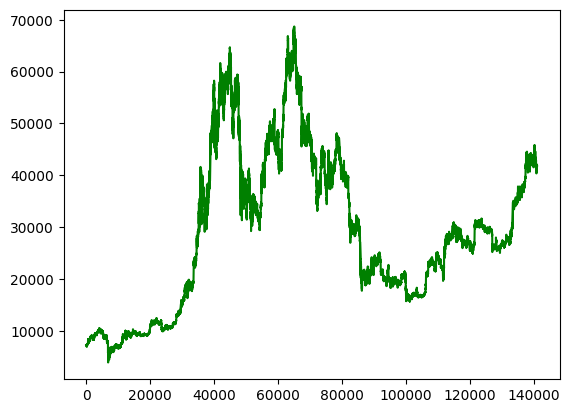

In [2]:
x_axis = []
for i in range(len(data)):
    x_axis.append(i)



plt.plot(x_axis, data['Close'].to_numpy(), label='BTC Trend', color='green')
plt.show()

In [3]:
def identify_crossovers(cross_data):
        cross_data['cross'] = 0
        cross_data.loc[(cross_data['ema12'] > cross_data['ema26']), 'cross'] = 1
        cross_data['crossover'] = cross_data['cross'].diff()
        return cross_data[cross_data['crossover'] != 0]

cross_data = pd.read_csv("cleaned_btc_15m_02.csv")
cross_data['ema12'] = cross_data['Close'].ewm(span=60, adjust=False).mean()
cross_data['ema26'] = cross_data['Close'].ewm(span=161, adjust=False).mean()

crossovers = identify_crossovers(cross_data)

if crossovers['cross'].iloc[-1] == 1:
        # Create a new row with desired values
        new_row = {'Date': cross_data['Date'].iloc[-1], 'Close': cross_data['Close'].iloc[-1], 'cross': 0}
        # Add the new row to the DataFrame using loc
        crossovers = crossovers.append(new_row, ignore_index=True)

print(crossovers)
print(crossovers.columns)
crossovers.to_csv("crossovers_data.csv", index=False)
#check_date = crossovers.iloc[-1]['timestamp']
#cross_direc = crossovers.iloc[-1]['cross'] #0 = SELL   1 = BUY

                    Date      Open      High       Low     Close       Volume  \
0    2020-01-01 00:00:00   7195.24   7196.25   7178.20   7180.97   202.942868   
1    2020-01-01 01:00:00   7176.47   7194.04   7175.71   7190.86   103.520522   
2    2020-01-02 03:30:00   7156.62   7161.00   7137.64   7142.37   433.788610   
3    2020-01-03 09:30:00   7310.86   7317.07   7298.08   7310.57   721.812028   
4    2020-01-09 04:15:00   7930.08   7954.30   7928.29   7941.35   526.437682   
..                   ...       ...       ...       ...       ...          ...   
814  2024-01-03 13:15:00  42539.87  42694.00  42315.99  42468.28  1679.415900   
815  2024-01-04 19:30:00  44384.21  44437.50  44031.10  44099.32   789.701500   
816  2024-01-16 06:45:00  42736.78  42774.00  42704.61  42741.09   153.882020   
817  2024-01-20 21:45:00  41795.92  41816.00  41729.90  41733.85   100.158930   
818  2024-01-21 10:45:00       NaN       NaN       NaN  41809.18          NaN   

            ema12         e

C:\Users\bestz\AppData\Local\Temp\ipykernel_14392\159995760.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  crossovers = crossovers.append(new_row, ignore_index=True)


In [4]:

crossovers_data = pd.read_csv("crossovers_data.csv")
crossovers_data = crossovers_data.drop(['Open', 'High', 'Low', 'Volume', 'ema12', 'ema26', 'crossover'], axis=1)
#crossovers_data = crossovers_data.drop(['Open', 'High', 'Low', 'Volume', 'ema12', 'ema26', 'crossover', 'Adj Close'], axis=1)
#crossovers_data['percent_change'] = crossovers_data['Close'].pct_change()*100
crossovers_data['qty_btc'] = None
crossovers_data['balance_usdt'] = None
crossovers_data['pct_cum'] = None
#print(crossovers_data)

start_value = 100 #USDT
for i in range(len(crossovers_data)):
    #print(crossovers_data['Close'].loc[i])
    if crossovers_data['cross'].iloc[i] == 1: #buy
        crossovers_data['qty_btc'].iloc[i] = (start_value/crossovers_data['Close'].iloc[i]) * 0.999
        crossovers_data['balance_usdt'].iloc[i] = crossovers_data['Close'].iloc[i] * crossovers_data['qty_btc'].iloc[i]
        crossovers_data['pct_cum'].iloc[i] = (crossovers_data['balance_usdt'].iloc[i] - 100)
    
    if crossovers_data['cross'].iloc[i] == 0 and i > 0: #sell
        crossovers_data['qty_btc'].iloc[i] = crossovers_data['qty_btc'].iloc[i-1]
        crossovers_data['balance_usdt'].iloc[i] = (crossovers_data['Close'].iloc[i] * crossovers_data['qty_btc'].iloc[i]) * 0.999
        start_value = crossovers_data['balance_usdt'].iloc[i]
        crossovers_data['pct_cum'].iloc[i] = (crossovers_data['balance_usdt'].iloc[i] - 100)

print(crossovers_data)

C:\Users\bestz\AppData\Local\Temp\ipykernel_14392\3055399178.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crossovers_data['qty_btc'].iloc[i] = (start_value/crossovers_data['Close'].iloc[i]) * 0.999
C:\Users\bestz\AppData\Local\Temp\ipykernel_14392\3055399178.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crossovers_data['balance_usdt'].iloc[i] = crossovers_data['Close'].iloc[i] * crossovers_data['qty_btc'].iloc[i]
C:\Users\bestz\AppData\Local\Temp\ipykernel_14392\3055399178.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

                    Date     Close  cross   qty_btc balance_usdt     pct_cum
0    2020-01-01 00:00:00   7180.97      0      None         None        None
1    2020-01-01 01:00:00   7190.86      1  0.013893         99.9        -0.1
2    2020-01-02 03:30:00   7142.37      0  0.013893     99.12712    -0.87288
3    2020-01-03 09:30:00   7310.57      1  0.013546    99.027993   -0.972007
4    2020-01-09 04:15:00   7941.35      0  0.013546   107.464881    7.464881
..                   ...       ...    ...       ...          ...         ...
814  2024-01-03 13:15:00  42468.28      0  0.011508    488.23052   388.23052
815  2024-01-04 19:30:00  44099.32      1   0.01106    487.74229   387.74229
816  2024-01-16 06:45:00  42741.09      0   0.01106   472.247428  372.247428
817  2024-01-20 21:45:00  41733.85      1  0.011304   471.775181  371.775181
818  2024-01-21 10:45:00  41809.18      0  0.011304   472.154113  372.154113

[819 rows x 6 columns]


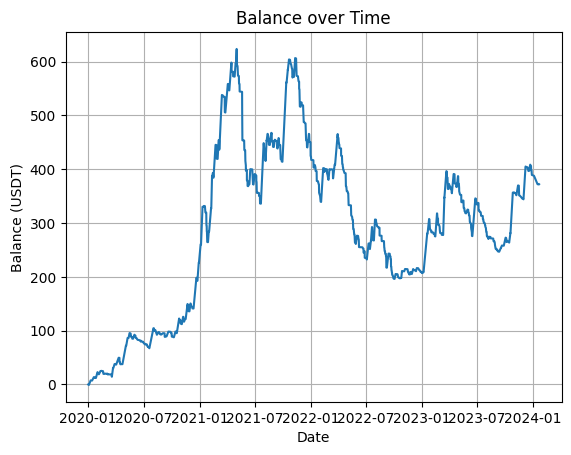

In [5]:
crossovers_data['Date'] = pd.to_datetime(crossovers_data['Date'])  # Convert 'Date' column to datetime type

plt.plot(crossovers_data['Date'], crossovers_data['pct_cum'])
plt.xlabel('Date')
plt.ylabel('Balance (USDT)')
plt.title('Balance over Time')
plt.grid(True)
plt.show()

                 Date     Open     High      Low    Close      Volume  \
0 2020-01-01 00:00:00  7195.24  7196.25  7178.20  7180.97  202.942868   
1 2020-01-01 00:15:00  7180.97  7186.40  7175.47  7178.45  128.242654   
2 2020-01-01 00:30:00  7178.19  7185.44  7176.23  7179.56   83.487458   
3 2020-01-01 00:45:00  7179.35  7183.98  7175.46  7177.02   97.141921   
4 2020-01-01 01:00:00  7176.47  7194.04  7175.71  7190.86  103.520522   

       cum_pnl  
0  1470.180604  
1  1469.629585  
2  1469.872296  
3  1469.316903  
4  1472.343137  


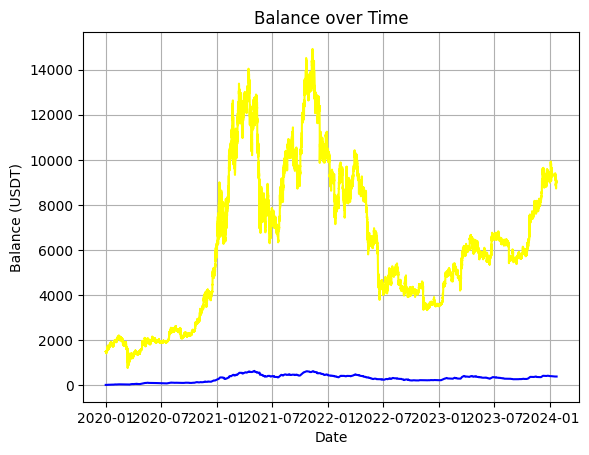

In [6]:
data = pd.read_csv("cleaned_btc_15m_02.csv")
data['Date'] = pd.to_datetime(data['Date'])  # Convert 'Date' column to datetime type
data['cum_pnl'] = ((data['Close'] - 457.334015)/457.334015)*100
print(data.head(5))

plt.plot(data['Date'], data['cum_pnl'], label='BTC Trend', color='yellow')
plt.plot(crossovers_data['Date'], crossovers_data['pct_cum'], label='ema_pnl', color='blue')
plt.xlabel('Date')
plt.ylabel('Balance (USDT)')
plt.title('Balance over Time')
plt.grid(True)
plt.show()

                 Date     Open     High      Low    Close      Volume
0 2020-01-01 00:00:00  7195.24  7196.25  7178.20  7180.97  202.942868
1 2020-01-01 00:15:00  7180.97  7186.40  7175.47  7178.45  128.242654
2 2020-01-01 00:30:00  7178.19  7185.44  7176.23  7179.56   83.487458
3 2020-01-01 00:45:00  7179.35  7183.98  7175.46  7177.02   97.141921
4 2020-01-01 01:00:00  7176.47  7194.04  7175.71  7190.86  103.520522


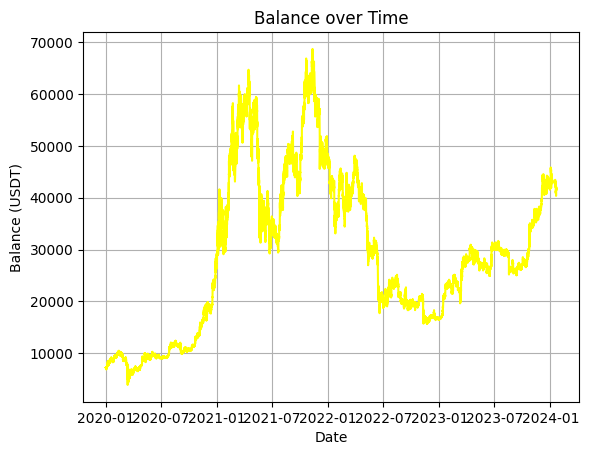

In [14]:
data = pd.read_csv("cleaned_btc_15m_02.csv")
data = data.sort_values(by='Date')
data['Date'] = pd.to_datetime(data['Date'])  # Convert 'Date' column to datetime type
print(data.head(5))

plt.plot(data['Date'], data['Close'], label='BTC Trend', color='yellow')
plt.xlabel('Date')
plt.ylabel('Balance (USDT)')
plt.title('Balance over Time')
plt.grid(True)
plt.show()